**# Batch Normalization**

# 从零开始实现

In [ ]:
!pip install d2l
!pip install matplotlib==3.0

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # moving_mean 和 moving_var 代表全局的均值和方差
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        # 2 表示全连接层，batch_size + feature，维度为2
        # 4 表示卷积层，batch_size + channels + height + width, 维度为4
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0) 
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # X.mean.shape = (1,n,1,1)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)  # X.var.shape = (1,n,1,1)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差，指数移动加权平均
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

* 创建一个正确的BatchNorm图层

In [ ]:
class BatchNorm(nn.Module):
    # num_features：全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

* 应用BatchNorm于LeNet模型

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

* 在Fashion-MNIST数据集上训练网络

loss 0.261, train acc 0.904, test acc 0.850
14314.7 examples/sec on cuda:0


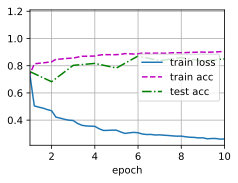

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) 
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([4.5902, 3.3914, 2.1099, 2.8099, 2.1680, 3.4243], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 2.0572, -1.5376, -2.1197, -3.0951,  2.5912,  1.6586], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

# 简洁实现

* 调用nn.BatchNorm2d()实现，填入num_features：全连接层的输出数量或卷积层的输出通道数。

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.274, train acc 0.898, test acc 0.856
26893.9 examples/sec on cuda:0


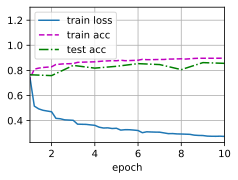

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())